In [10]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from openap import prop

# -------------------------
# 0. Load aircraft and engine data
# -------------------------
fiche_ac = prop.aircraft("A320")
fiche_engine = prop.engine("CFM56-5-A1")
fiche_control = {
    'k_gamma': 0.45 # P controller gain for flight path angle
}

# -------------------------
# 1. Conversion factors and target values
# -------------------------
knots_to_ms = 0.514444
ft_to_m     = 0.3048

# Speeds (m/s)
v_250 = 250 * knots_to_ms        # ~128.61 m/s
v_300 = 300 * knots_to_ms        # ~154.33 m/s
v_mach78 = 0.78 * 340            # ~265.2 m/s (approx.)

# Altitudes (m)
h_takeoff_end   = 1000 * ft_to_m    # 1,000 ft
h_climb1_end    = 10000 * ft_to_m     # 10,000 ft
h_climb2_end    = 20000 * ft_to_m     # 20,000 ft
h_cruise        = 35000 * ft_to_m     # 35,000 ft
h_descent3_end  = 100 * ft_to_m       # ~100 ft for final descent start
h_landing_end   = 0.0                 # ground

# -------------------------
# 2. Define the aircraft dynamics function (same as before)
# -------------------------
def aircraft_dynamics(x, u, wind_s, phi, phase, fiche_engine, fiche_ac, fiche_control, num_engines = 2):
    """
    Computes the state derivative for the vertical dynamics.
    x = [v, gamma, h, s, m] # speed, flight path angle, altitude, along-path distance, mass
    u = [T, gamma_ref, beta] # thrust, reference flight path angle, speedbrake parameter
    """
    g = 9.81  # gravitational acceleration (m/s^2)

    # Unpack control parameters
    k_gamma = fiche_control['k_gamma']
    
    # Unpack state and control

    # v, gamma, h, s, m = x[0], x[1], x[2], x[3], x[4] # speed, flight path angle, altitude, along-path distance, mass
    v, gamma, h, s, m = x[0], x[1], x[2], x[3], x[4] # speed, reference flight path angle, altitude, along-path distance, mass
    T, gamma_ref, beta = u[0], u[1], u[2] # thrust, controlled flight path angle, speedbrake parameter
    
    # --- Drag Model ---
    rho0 = 1.225  # sea-level density [kg/m^3]
    H    = 8500.0 # scale height [m]
    rho  = rho0 * ca.exp(-h/H) # air density [kg/m^3] - exponential model

    # --- Load factor calculation ---
    # nz = (-v * k_gamma * (gamma - gamma_ref) + g * ca.cos(gamma_ref))/(g * ca.cos(phi))
    nz = (-v * k_gamma * (gamma - gamma_ref) + g * ca.cos(gamma))/(g * ca.cos(phi))

    # --- Lift/Drag Calculations ---
    # Required lift force to maintain load factor nz
    L = nz * m * g

    # To avoid division by zero when computing Cl, add a small epsilon to v**2.
    epsilon = 1e-6
    v_sq = v**2 + epsilon


    S_area = fiche_ac['wing']['area']  # wing area (example value) [m^2]

    # Compute the lift coefficient from L = 0.5 * rho * v^2 * S_area * Cl.
    Cl = L / (0.5 * rho * v_sq * S_area)
    
    k = fiche_ac['drag']['k']
    Cd = fiche_ac['drag']['cd0'] + beta + k * Cl**2  # parabolic drag model
    D = 0.5 * rho * v**2 * S_area * Cd  # Drag force [N]

    if phase == 'cruise':
        # --- Revised Fuel Flow Model ---
        # Convert engine cruise SFC from kg/(N·hr) to kg/(N·s)
        cruise_sfc = fiche_engine['cruise_sfc'] / 3600.0  # [kg/(N·s)]
        fuel_coef = fiche_ac['fuel']['fuel_coef']      # scaling coefficient
        fuel_flow = fuel_coef * cruise_sfc * T  # fuel flow [kg/s]
    elif phase == 'takeoff':
        fuel_flow = fiche_engine['ff_to'] * num_engines
    elif phase == 'climb1' or phase == 'climb2' or phase == 'climb3':
        fuel_flow = fiche_engine['ff_co'] * num_engines
    elif phase == 'descent1' or phase == 'descent2' or phase == 'descent3':
        fuel_flow = fiche_engine['ff_app'] * num_engines
    elif phase == 'landing':
        fuel_flow = fiche_engine['ff_idl'] * num_engines
    
    # Dynamics equations
    v_dot     = (T - D) / m - g * ca.sin(gamma)
    # gamma_dot = (g / v) * (nz * ca.cos(phi) - ca.cos(gamma))
    gamma_dot = k_gamma * (gamma_ref - gamma)
    h_dot     = v * ca.sin(gamma)
    s_dot     = v * ca.cos(gamma) + wind_s  # along-path distance, plus wind component
    m_dot     = -fuel_flow
    
    return ca.vertcat(v_dot, gamma_dot, h_dot, s_dot, m_dot)

# -------------------------
# 3. Phase definitions
# -------------------------
# Each phase is defined by:
#   - name: label for the phase
#   - N: number of discretization intervals in this phase
#   - h0: desired initial altitude (m) for the phase
#   - hF: desired final altitude (m) for the phase
#   - v_target: prescribed speed (m/s) if the phase has a fixed speed profile, or None.
#       (For phases with a constant altitude cruise, we can also enforce h constant.)
#   - Additional boundary conditions on v (if desired) can be set in the takeoff/landing phases.
phases = [
    {"name": "climb1",   "N": 50, "h0": 0.0,          "hF": h_climb1_end,  "v_target": v_250},   # v free; later we set v(0)=0 and v(end)=v_250
]

# -------------------------
# 4. Set up the Opti problem and common parameters
# -------------------------
opti = ca.Opti()

# Common parameters for all phases
wind_s = opti.parameter();  opti.set_value(wind_s, 0.0)  # assume zero wind for simplicity
phi    = opti.parameter();  opti.set_value(phi, 0.0)     # bank angle zero in vertical dynamics
CI     = opti.parameter();  opti.set_value(CI, 1.0)        # cost index weight

# We'll store the variables for each phase in lists:
X_list = []  # states for each phase
U_list = []  # controls for each phase
T_list = []  # phase durations (free final time for each phase)
N_list = []  # discretization intervals for each phase
phase_names = []

# -------------------------
# 5. Create decision variables for each phase
# -------------------------
# Here the state vector is: [v, gamma, h, s, m]
# We impose some boundary conditions within each phase (e.g., desired altitude at phase start/end)
for phase in phases:
    name = phase["name"]
    phase_names.append(name)
    N_phase = phase["N"]
    N_list.append(N_phase)
    
    # Phase duration is free (initial guess provided later)
    T_phase = opti.variable()
    opti.set_initial(T_phase, 100.0)  # initial guess (seconds)
    T_list.append(T_phase)
    dt = T_phase / N_phase  # time step for this phase
    
    # States: dimension 5 x (N_phase+1)
    X = opti.variable(5, N_phase+1)
    # Controls: dimension 3 x (N_phase)
    U = opti.variable(3, N_phase)
    
    # Save to lists
    X_list.append(X)
    U_list.append(U)
    
    # Dynamics (multiple shooting using explicit Euler)
    for k in range(N_phase):
        xk = X[:, k]
        uk = U[:, k]
        x_next = X[:, k+1]
        # Euler integration:
        x_next_euler = xk + dt * aircraft_dynamics(xk, uk, wind_s, phi, name, fiche_engine, fiche_ac, fiche_control)
        opti.subject_to(x_next == x_next_euler)
    
    # Impose altitude boundary conditions for the phase:
    #   h (state index 2) at start and end
    opti.subject_to(X[2, 0] == phase["h0"])
    opti.subject_to(X[2, -1] == phase["hF"])
    
    # If a phase is meant to be flown at a prescribed speed, add path constraints:
    if phase["v_target"] is not None:
        # For all nodes in this phase, enforce v = v_target (state index 0)
        for k in range(N_phase+1):
            opti.subject_to(X[0, k] == phase["v_target"])
    
    # For the cruise phase, we also fix altitude (h) at every node.
    if name == "cruise":
        for k in range(N_phase+1):
            opti.subject_to(X[2, k] == h_cruise)
    
    # (Optionally, one might add bounds on gamma, s, and mass.)
    # Here we add some reasonable bounds (same for every phase):
    for k in range(N_phase+1):
        # Speed bounds (m/s)
        opti.subject_to(X[0, k] >= 0)
        opti.subject_to(X[0, k] <= 350)
        # Flight path angle bounds (rad)
        opti.subject_to(X[1, k] >= -0.5)
        opti.subject_to(X[1, k] <= 0.5)
        # Altitude bounds (m)
        opti.subject_to(X[2, k] >= 0)
        opti.subject_to(X[2, k] <= 12000)
        # Along–path distance s is free (>=0)
        opti.subject_to(X[3, k] >= 0)
        # Mass bounds (kg)
        opti.subject_to(X[4, k] >= 50000)
        opti.subject_to(X[4, k] <= 90000)
    
    # Also add bounds on the controls for each interval:
    for k in range(N_phase):
        # Thrust bounds [N]
        opti.subject_to(U[0, k] >= 0)
        opti.subject_to(U[0, k] <= 100000)
        # Flight path angle bounds
        opti.subject_to(U[1, k] >= -0.5)
        opti.subject_to(U[1, k] <= 0.5)
        # Beta (e.g., speedbrake parameter) bounds
        opti.subject_to(U[2, k] >= 0.0)
        opti.subject_to(U[2, k] <= 0.5)

# -------------------------
# 7. Impose boundary conditions on takeoff and landing phases
# -------------------------
# For take-off: initial state: v=30, gamma=0, h=0, s=0, m = initial mass (say 70000 kg)
x0 = np.array([108.03, 0.0, 0.0, 0.0, 70000.0])
# For phase specific constraints and ICs, use X_list (instead of X like above. They are just the same thing)
opti.set_initial(X_list[0][:, 0], x0)
opti.subject_to(X_list[0][3, 0] == 0.0)   # along-path distance starts at 0

# For take-off, we want the final speed to be the target for climb1 (v_250):
# At the end of the takeoff, altitude should be h_takeoff_end
opti.subject_to(X_list[0][0, -1] == v_250)

# -------------------------
# 8. Define the overall cost function
# -------------------------
# The running cost in each phase is:
#   J_phase = sum_{k=0}^{N-1} (fuel_flow + CI)*dt
# where fuel_flow is computed from thrust T as in the dynamics.
total_cost = 0
for i, phase in enumerate(phases):
    N_phase = phase["N"]
    T_phase = T_list[i]
    dt = T_phase / N_phase
    X = X_list[i]
    U = U_list[i]
    # Sum cost over intervals in phase i
    J_phase = 0
    for k in range(N_phase):
        T_k = U[0, k]
        # Fuel flow as in the dynamics:
        fuel_flow_k = 0.0001 * T_k  # [kg/s]
        #  J_phase += (fuel_flow_k + CI) * dt 
        J_phase += (CI) * dt
    total_cost += J_phase
opti.minimize(total_cost)

# -------------------------
# 9. Initial guesses for the states in each phase (for smoother convergence)
# -------------------------
# We linearly interpolate altitude between the phase boundaries.
for i, phase in enumerate(phases):
    N_phase = phase["N"]
    X = X_list[i]
    # For each node, set altitude to a linear interpolation between h0 and hF.
    for k in range(N_phase+1):
        h_guess = phase["h0"] + (phase["hF"] - phase["h0"]) * k / N_phase
        opti.set_initial(X[2, k], h_guess)
    # For the speed, if a target is prescribed, that will be enforced; otherwise,
    # we set a linear ramp. For takeoff, ramp from 0 to v_250.
    if phase["v_target"] is None:
        if phase["name"] == "takeoff":
            for k in range(N_phase+1):
                v_guess = 0 + (v_250 - 0) * k / N_phase
                opti.set_initial(X[0, k], v_guess)
    # For other states (gamma, s, m) we provide rough guesses.
    for k in range(N_phase+1):
        opti.set_initial(X[1, k], 0.0)  # flight path angle near zero
        opti.set_initial(X[3, k], 1000.0 * (i + k/float(N_phase)))  # along-path distance increasing
        opti.set_initial(X[4, k], 70000.0 - 1000*i)  # mass decreasing gradually

    # For controls, use moderate values.
    U = U_list[i]
    for k in range(N_phase):
        opti.set_initial(U[0, k], 50000.0)   # thrust guess
        opti.set_initial(U[1, k], 0.0)       # flight path angle guess
        opti.set_initial(U[2, k], 0.0)       # beta guess

# -------------------------
# 10. Solve the NLP
# -------------------------
p_opts = {"expand": True}
s_opts = {"max_iter": 500, "print_level": 5, "tol":1e-6, "acceptable_tol":1e-4}  #Added tolerance
opti.solver('ipopt', p_opts, s_opts)

# -------------------------
# Debugging information
# -------------------------


try:
    sol = opti.solve()  # Use opti.solve() for the regular solution
except RuntimeError as e:
    print("Solver error:", e)

    # Inspect values at the point where the error occurred
    print("\n--- Debugging Information ---")
    for i, phase in enumerate(phases):
        print(f"\nPhase: {phase['name']}")
        X_debug = opti.debug.value(X_list[i])
        U_debug = opti.debug.value(U_list[i])
        T_debug = opti.debug.value(T_list[i])

        print("  States (X) [v, fpa, h, s, m]:")
        print(X_debug)
        print("  Controls (U) [thrust, fpa, spdbrk]:")
        print(U_debug)
        print(f"  Duration (T): {T_debug}")

        # if "Infeasible_Problem_Detected" in str(e):
            # print("Solver detected infeasibility. Analyzing...")
            # opti.debug.show_infeasibilities()  # Show summary


        # Plot the states
        from state_plot import plot_states
        # plot_states(X_debug[0], X_debug[1], X_debug[2], X_debug[3], X_debug[4], U_debug[0], U_debug[1], U_debug[2])

        X_ext = np.empty((6, phase['N']))

        # Compute the additional variables
        for k in range(phase['N']):
            xk = X_debug[:,k]
            uk = U_debug[:,k]
            dyn_func = aircraft_dynamics(xk, uk, opti.debug.value(wind_s), opti.debug.value(phi), phase['name'], fiche_engine, fiche_ac, fiche_control)
            dyn_values = opti.debug.value(dyn_func)

            #Further break down
            g = 9.81
            k_gamma = fiche_control['k_gamma']
            v, gamma, h, s, m = xk[0], xk[1], xk[2], xk[3], xk[4]
            T, gamma_ref, beta = uk[0], uk[1], uk[2]
            rho0 = 1.225
            H = 8500.0
            rho = rho0 * np.exp(-h / H)  # Use numpy for scalar calculations during debugging
            nz = (-v * k_gamma * (gamma - gamma_ref) + g * np.cos(gamma))/(g * np.cos(0))
            L = nz * m * g
            epsilon = 1e-6
            v_sq = v**2 + epsilon
            S_area = fiche_ac['wing']['area']
            Cl = L / (0.5 * rho * v_sq * S_area)
            k_drag = fiche_ac['drag']['k']
            Cd = fiche_ac['drag']['cd0'] + beta + k_drag * Cl**2
            D = 0.5 * rho * v**2 * S_area * Cd

            X_ext[:,k] = np.array([L, D, nz, Cl, Cd, rho])

        from state_plot import plot_states, plot_states_ext
        plot_states(X_debug[0], X_debug[1], X_debug[2], X_debug[3], X_debug[4], U_debug[0], U_debug[1], U_debug[2])
        plot_states_ext(X_ext[0], X_ext[1], X_ext[2], X_ext[3], X_ext[4], X_ext[5])



    sol = opti.debug  # Use opti.debug to access variable values after the error
    #exit() #Commented this so plots still generated

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1355
Number of nonzeros in inequality constraint Jacobian.:      759
Number of nonzeros in Lagrangian Hessian.............:     1300

Total number of variables............................:      406
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      305
Total number of inequality constraints...............:      759
        inequality constraints with only lower bounds:      405
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      354

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+02 1.96e+02 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

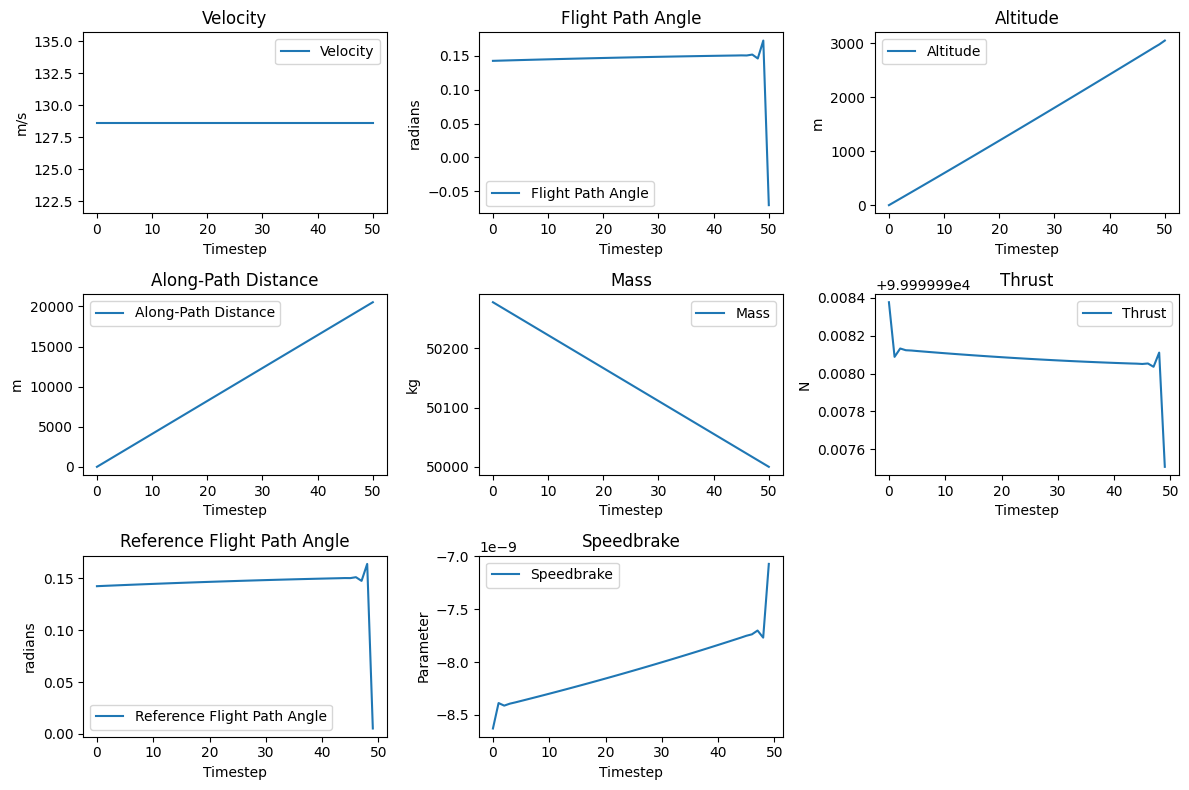

Phase completed in 161.3251486205112 seconds


In [13]:
# Plot sol
X_debug = opti.debug.value(X_list[i])
U_debug = sol.value(U_list[i])
T_debug = sol.value(T_list[i])

plot_states(X_debug[0], X_debug[1], X_debug[2], X_debug[3], X_debug[4], U_debug[0], U_debug[1], U_debug[2])
print(f'Phase completed in {T_debug} seconds')

In [8]:
# Compute the additional variables
for k in range(phase['N']):
    xk = X_debug[:,k]
    uk = U_debug[:,k]
    dyn_func = aircraft_dynamics(xk, uk, opti.debug.value(wind_s), opti.debug.value(phi), phase['name'], fiche_engine, fiche_ac, fiche_control)
    dyn_values = opti.debug.value(dyn_func)

    #Further break down
    g = 9.81
    k_gamma = fiche_control['k_gamma']
    v, gamma, h, s, m = xk[0], xk[1], xk[2], xk[3], xk[4]
    T, gamma_ref, beta = uk[0], uk[1], uk[2]
    rho0 = 1.225
    H = 8500.0
    rho = rho0 * np.exp(-h / H)  # Use numpy for scalar calculations during debugging
    nz = (-v * k_gamma * (gamma - gamma_ref) + g * np.cos(gamma))/(g * np.cos(0))
    L = nz * m * g
    epsilon = 1e-6
    v_sq = v**2 + epsilon
    S_area = fiche_ac['wing']['area']
    Cl = L / (0.5 * rho * v_sq * S_area)
    k_drag = fiche_ac['drag']['k']
    Cd = fiche_ac['drag']['cd0'] + beta + k_drag * Cl**2
    D = 0.5 * rho * v**2 * S_area * Cd

    X_ext[:,k] = np.array([nz, L, D, Cl, Cd, rho])
